## Nos conectamos a google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Descargamos tensor flow porque hasta ahroita tengo problemas con el modelo

## Descargamos el api de detección de objetos

## Descargamos slim para poder hacer más fácilmente modelos, pues nos proporciona varias caracteristicas

In [2]:
!pip install tensorflow
!pip install tensorflow-object-detection-api
!pip install tf_slim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.4/577.4 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.1/777.1 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.7 MB/s eta 0:00:00
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-py3-none-any.whl size=844487 sha256=267eecff3c3573f38c9e24070bc70ded544430646afd5744488e090a6a6acded
  Stored in directory: /root/.cache/pip/wheels/8a/55/68/c084bc2cd93c41fd8f7e2ef9e6bbcb2c35a3e4b49e42044d02
Successfully built tensorflow-object-detection-api


## Descargamos el modelo preentrenado y sus archivos para la configuracióm del pipeline

In [3]:

# !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
# !tar -xzvf efficientdet_d0_coco17_tpu-32.tar.gz

# !cp efficientdet_d0_coco17_tpu-32/pipeline.config ./pipeline.config

# modelo preentrenado
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
!tar -xzvf efficientdet_d0_coco17_tpu-32.tar.gz
!cp efficientdet_d0_coco17_tpu-32/pipeline.config ./pipeline.config



--2024-05-19 06:35:45--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.12.207, 108.177.11.207, 74.125.26.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.12.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz.1’

efficientdet_d0_coc 100%[===================>]  29.31M  --.-KB/s    in 0.1s    

2024-05-19 06:35:46 (222 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz.1’ saved [30736482/30736482]

efficientdet_d0_coco17_tpu-32/
efficientdet_d0_coco17_tpu-32/checkpoint/
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d0_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d0_coco17_tpu-32/pipeline.config
efficientdet_d0_coco17_tpu-32/saved_model

## Vemos qeu tenemos en la carpeta

In [4]:
%cd "/content/drive/MyDrive/IA/IA 2/RetoTF"
!ls

/content/drive/MyDrive/IA/IA 2/RetoTF
efficientdet_d0_coco17_tpu-32		efficientdet_d0_coco17_tpu-32.tar.gz.3	test
efficientdet_d0_coco17_tpu-32.tar.gz	models					train
efficientdet_d0_coco17_tpu-32.tar.gz.1	pipeline.config				valid
efficientdet_d0_coco17_tpu-32.tar.gz.2	SuperSmashDetector.ipynb


### Configurando el modelo preentrenado, llamando lo que es el pipeline del modelo

In [5]:
import re

pipeline_config = 'pipeline.config'
with open(pipeline_config) as f:
    config = f.read()

config = re.sub('num_classes: 90', 'num_classes: 80', config)
config = re.sub('fine_tune_checkpoint: ".*?"', 'fine_tune_checkpoint: "efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0"', config)
config = re.sub('input_path: ".*?val.record"', 'input_path: "/content/drive/MyDrive/IA/IA 2/RetoTF/valid/fighter.tfrecord"', config)
config = re.sub('input_path: ".*?train.record"', 'input_path: "/content/drive/MyDrive/IA/IA 2/RetoTF/train/fighter.tfrecord"', config)
config = re.sub('label_map_path: ".*?"', 'label_map_path: "/content/drive/MyDrive/IA/IA 2/RetoTF/train/fighter_label_map.pbtxt"', config)
config = re.sub('batch_size: 24', 'batch_size: 8', config)

with open(pipeline_config, 'w') as f:
    f.write(config)

### - Funcion para leer los TFRecords y poder entenderlos
### - Funcion para cargar dataset
### - Funcion para hacer data augmentation


In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Función para parsear un TFRecord y entenderlo
def parse_tfrecord(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/source_id': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'image/filename': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'image/format': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'image/height': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        'image/width': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    return tf.io.parse_single_example(example, feature_description)


def load_dataset(filenames):
    options = tf.data.Options()
    options.experimental_deterministic = False #Ignoramos el orden para que sea rapido la carga de datos
    dataset = tf.data.TFRecordDataset(filenames) #Creamos el dataset
    dataset = dataset.with_options(options) #Le aplicamos las opciones
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE) #Hacemos un mapa con los datos
    return dataset

def data_augmentation(image):
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))#Gira90
    image = tf.image.random_flip_left_right(image) #La invertimos
    image = tf.image.random_contrast(image, lower=0.5, upper=1) #Cambio de contraste
    image = tf.image.random_saturation(image, lower=0.5, upper=1)
    image = tf.image.random_brightness(image, max_delta=15)
    image = tf.image.random_hue(image, max_delta=0.02)
    return image

#Lo pasas a JPEG  para poder hacerel eel data augmentation
def preprocess_data(data):
    image = tf.io.decode_jpeg(data['image/encoded'], channels=3)
    image = tf.image.resize(image, [350, 350])
    image = data_augmentation(image)
    return image, data

## Dividimos el data set en train y validation y aplicamos el data augmentation

In [14]:
# Directorio de los archivos TFRecord
# train_files = ['/content/drive/MyDrive/IA/IA 2/Reto/train/fighter.tfrecord']
# val_files = ['/content/drive/MyDrive/IA/IA 2/Reto/valid/fighter.tfrecord']

# train_dataset = load_dataset(train_files)
# val_dataset = load_dataset(val_files)

# train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dataset = train_dataset.batch(8).prefetch(tf.data.experimental.AUTOTUNE)
# val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# val_dataset = val_dataset.batch(8).prefetch(tf.data.experimental.AUTOTUNE)

train_files = ['/content/drive/MyDrive/IA/IA 2/RetoTF/train/fighter.tfrecord']
val_files = ['/content/drive/MyDrive/IA/IA 2/RetoTF/valid/fighter.tfrecord']

train_dataset = load_dataset(train_files)
val_dataset = load_dataset(val_files)

train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(8).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(8).prefetch(tf.data.AUTOTUNE)

## mostramos como se hizo el data augmentation

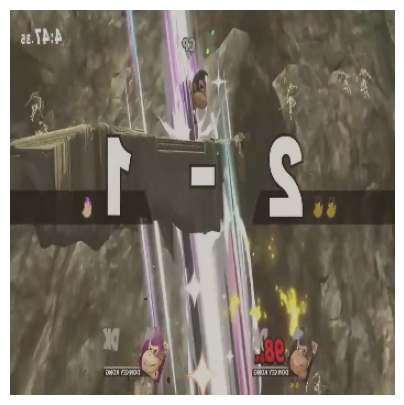

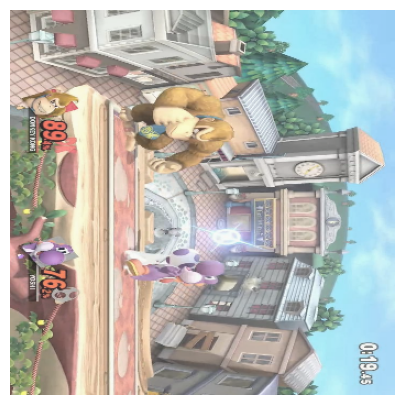

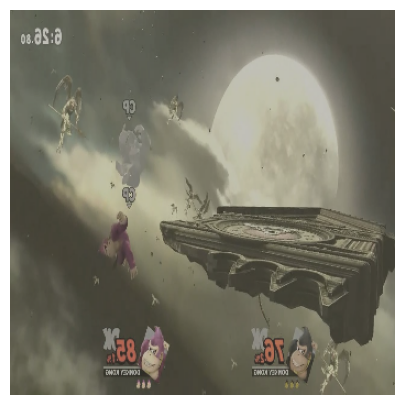

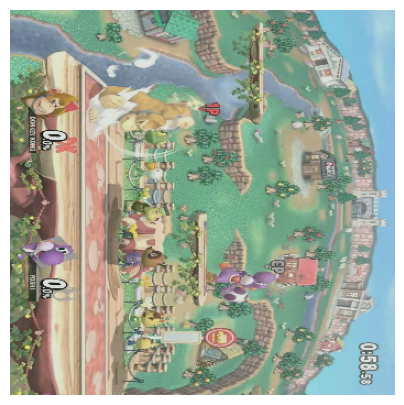

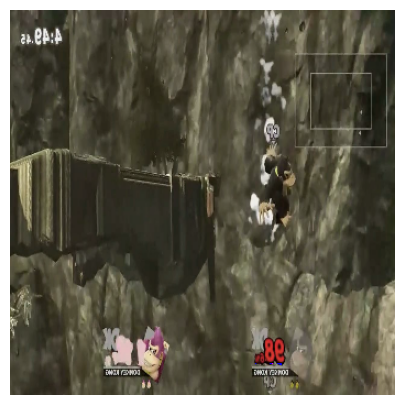

In [19]:

def show_image(image_tensor):
    plt.figure(figsize=(5, 5))
    plt.imshow(image_tensor.numpy().astype("uint8"))
    plt.axis('off')
    plt.show()

for image, data in train_dataset.take(5):
    show_image(image[0])


In [16]:
def count_elements(dataset):
    count = dataset.reduce(0, lambda x, _: x + 1)
    return count.numpy()

train_count = count_elements(train_dataset)

val_count = count_elements(val_dataset)

print("Número de ejemplos en el conjunto de entrenamiento:", train_count)
print("Número de ejemplos en el conjunto de validación:", val_count)


Número de ejemplos en el conjunto de entrenamiento: 648
Número de ejemplos en el conjunto de validación: 199


In [12]:
!pip install tensorflow==1.1.1

ERROR: Could not find a version that satisfies the requirement tensorflow==1.1.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==1.1.1


In [11]:
from object_detection.utils import config_util
from object_detection.builders import model_builder
from object_detection import model_lib_v2

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
train_config = configs['train_config']

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    detection_model = model_builder.build(model_config=model_config, is_training=True)

    optimizer, learning_rate_fn = model_lib_v2.build_optimizer(
        train_config.optimizer, train_config.learning_rate)
    tf.compat.v1.train.create_global_step()

    def train_step_fn(features, labels):
        with tf.GradientTape() as tape:
            loss_dict = detection_model(features, labels)
            total_loss = loss_dict['total_loss']
        gradients = tape.gradient(total_loss, detection_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, detection_model.trainable_variables))
        return loss_dict

    global_step = tf.compat.v1.train.get_or_create_global_step()

    @tf.function
    def distributed_train_step(dataset_inputs):
        per_replica_losses = strategy.run(train_step_fn, args=(dataset_inputs,))
        return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

    for epoch in range(int(train_config.num_steps)):
        for batch in train_dataset:
            loss_dict = distributed_train_step(batch)
            if epoch % 100 == 0:
                print(f'Step {epoch}: Loss = {loss_dict["total_loss"].numpy()}')

AttributeError: module 'tensorflow' has no attribute 'contrib'